In [41]:
# Import packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nemed
from nemed.downloader import download_current_aemo_cdeii_summary
import pprint
import ppa, residuals, tariffs, hybrid
import random

# Set up variables for loading csv w/ correct data types:
type_dict = {
    'DateTime' : 'str',
    'total_load' : 'float'
}
parse_dates = ['DateTime']

In [42]:
# Import load profiles and pricing data

# 1. One year of load and generation data
profiles = pd.read_csv('/Users/elliekallmier/Desktop/RA Work/mirvac/ppa_tool_python/MSAT-PPA-Python-master/data/all_generators.csv', dtype=type_dict, parse_dates=parse_dates)

# 2. One year of wholesale price data
price_data = pd.read_csv('/Users/elliekallmier/Desktop/RA Work/mirvac/ppa_tool_python/MSAT-PPA-Python-master/data/qld_prices_2021.csv')
price_data['ts'] = pd.to_datetime(price_data['SETTLEMENTDATE'])
price_data = price_data.set_index('ts').resample('30min').mean()
price_data['DateTime'] = pd.date_range("2021-01-01 00:30", periods=17521, freq="30min")
price_data = price_data.reset_index()
prices = price_data[['DateTime', 'RRP']]    # cleaned up pricing data for QLD 2021

In [43]:
# testing hyrbid functions:
ids = list(profiles.columns)[1:]
generators = ids[1:]

print(ids, '\n',  generators)

['total_load', 'Wind', 'KAREEYA2', 'CLARESF1', 'RRSF1', 'KAREEYA3', 'HAUGHT11', 'DAYDSF1', 'HAMISF1', 'LRSF1', 'KAREEYA1', 'RUGBYR1', 'SMCSF1', 'CSPVPS1', 'YARANSF1', 'KAREEYA4', 'CLERMSF1', 'WHITSF1', 'OAKEY1SF', 'MEWF1', 'WARWSF2', 'MARYRSF1', 'EMERASF1', 'WARWSF1', 'KSP1', 'LILYSF1', 'MIDDLSF1', 'PUMP1', 'COOPGWF1', 'HAYMSF1', 'PUMP2', 'DDSF1', 'SRSF1', 'OAKEY2SF', 'BARRON-2', 'BARRON-1', 'CHILDSF1', 'BARCSF1'] 
 ['Wind', 'KAREEYA2', 'CLARESF1', 'RRSF1', 'KAREEYA3', 'HAUGHT11', 'DAYDSF1', 'HAMISF1', 'LRSF1', 'KAREEYA1', 'RUGBYR1', 'SMCSF1', 'CSPVPS1', 'YARANSF1', 'KAREEYA4', 'CLERMSF1', 'WHITSF1', 'OAKEY1SF', 'MEWF1', 'WARWSF2', 'MARYRSF1', 'EMERASF1', 'WARWSF1', 'KSP1', 'LILYSF1', 'MIDDLSF1', 'PUMP1', 'COOPGWF1', 'HAYMSF1', 'PUMP2', 'DDSF1', 'SRSF1', 'OAKEY2SF', 'BARRON-2', 'BARRON-1', 'CHILDSF1', 'BARCSF1']


In [47]:
sample_gens = random.sample(generators, 3)
print(sample_gens)

['MIDDLSF1', 'BARRON-1', 'KAREEYA1']


In [60]:
# Write up objective function for optimisation?
def objective(x, profiles, gen_ids):
    #profiles, gen_ids = params
    gen_list = []
    name = f''

    for i in range(len(x)):
        gen_list.append((gen_ids[i], x[i]))
        name += f'{x[i]:.0%}'
  
    hybrid_profile = hybrid.create_hybrid(profiles, gen_list, name)
    scaled_hybrid = hybrid.scale_gen_profile(hybrid_profile, [name], scaling_period='Yearly')
    
    # Option 1: find exact amount of unmatched load ("black" or "firming" energy) and calculate the percentage of the total load that is unmatched:
    
    # residual_profile = residuals.calc(scaled_hybrid, load_id='total_load', generator_id=name)
    # black_energy = (np.sum(residual_profile['Black']))
    # load = np.sum(residual_profile['Load'])
    # test_quantity = 1 - black_energy/load


    # Option 2: find the average percentage match across each half-hourly time period and the RMSE - following Emily Yuan's procedure for optimisation. 

    scaled_hybrid['Match'] = np.where(scaled_hybrid[name]/scaled_hybrid['total_load']>1, 1, scaled_hybrid[name]/scaled_hybrid['total_load'])
    test_quantity = scaled_hybrid['Match'].mean()
    # scaled_hybrid['Squares'] = np.square(scaled_hybrid['total_load'] - scaled_hybrid[name])
    # rmse = np.sqrt(np.sum(scaled_hybrid['Squares'])/len(scaled_hybrid['total_load']))

    return 1-test_quantity#, rmse

mixes = [33/100, 33/100, 34/100]
params = profiles, sample_gens
match = objective(mixes, *params)
print(f'{params[1]}\n{match:.9%}')



['MIDDLSF1', 'BARRON-1', 'KAREEYA1']
20.889490560%


In [50]:
# Testing optimisation:
params = profiles, sample_gens
test = pd.DataFrame(columns = ['i', 'j', 'k', 'Unmatched'])

#count = 1000
def brute_force(interval):
    for i in np.arange(0, 100, interval):
        for j in np.arange(0, 100, interval):
            for k in np.arange(0, 100, interval):
                if i+j+k == 100:
                    mixes = [i/100, j/100, k/100]
                    match = objective(mixes, *params)
                    add = {'i':i, 'j':j, 'k':k, 'Unmatched':match}#, 'RMSE':rmse}
                    test.at[f'{i}/{j}/{k}', :] = add
                #count += 1
    print(test[test.Unmatched == test.Unmatched.min()])
    return 1
# print('\n')
# print(test[test.RMSE == test.RMSE.min()])

#%timeit brute_force()

brute_force(2)

             i     j     k Unmatched
58/16/26  58.0  16.0  26.0  0.172118


1

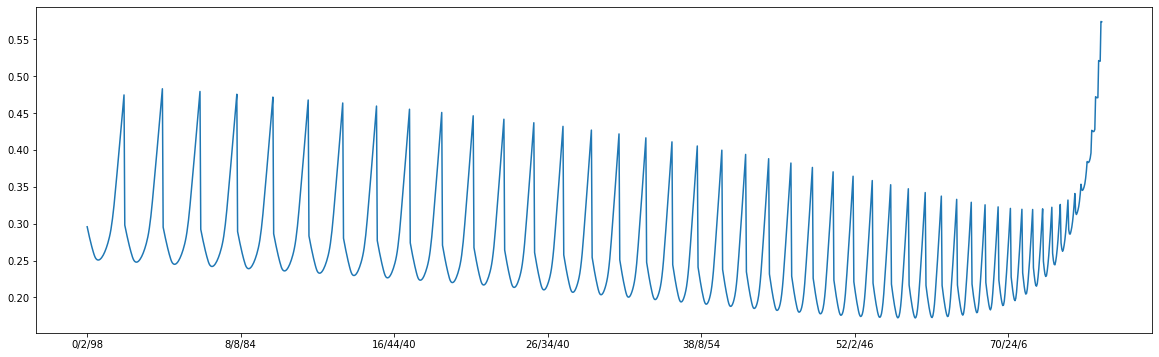

In [51]:
plt.figure(figsize=(20,6))
test['Unmatched'].plot()
plt.show()

In [78]:
params = profiles, sample_gens

from scipy import optimize
from scipy.optimize import Bounds, LinearConstraint, minimize

bounds = Bounds([0,0,0],[1,1,1])
linear_constr = LinearConstraint([[1,1,1],[1,1,1],[1,1,1]], [1,1,1], [1,1,1])

def constraint(x1, x2, x3):
    return 1 - (x1[0]+x1[1]+x1[2])

x0 = [10/100, 10/100, 80/100]

# res = minimize(objective, x0, params, method='Nelder-Mead', bounds=bounds)#, constraints=linear_constr)
# print(res.x)        # still not giving correct answer w/out constraints


res_2 = optimize.fmin_slsqp(objective, x0, eqcons=[constraint], args=params)
print(res_2)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2608792645377773
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
[0.1 0.1 0.8]


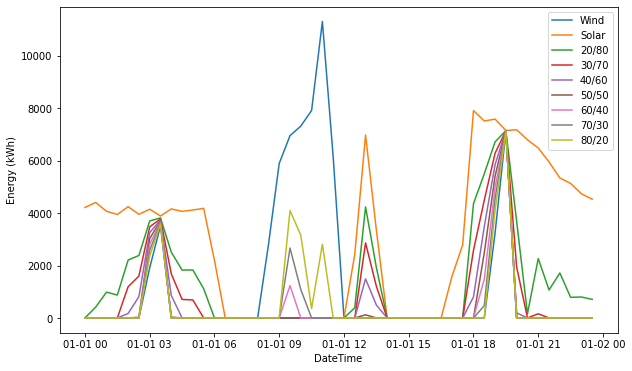

In [4]:
# 3. Calculate the residual profiles need for PPA and tariff calculations
residuals_dict = {}
re_gen_ids = ['Wind', 'Solar', '20/80', '30/70', '40/60', '50/50', '60/40', '70/30', '80/20']
for id in re_gen_ids:
    residual_profiles = residuals.calc(profiles, load_id='total_load', generator_id=id)
    resi = pd.DataFrame(data=residual_profiles).set_index('DateTime')
    residuals_dict[id] = resi

#resi.to_csv('data/residuals.csv')
# print('\n Load profiles used for cost calculations:')
# print(residual_profiles)

# 3(a). Plot Residuals
plt.figure(figsize=(10,6))
for id, data in residuals_dict.items():
    day_one = data.head(48)
    plt.plot(day_one.index, day_one['Black'], label=id)
plt.xlabel('DateTime')
plt.ylabel('Energy (kWh)')
plt.legend(loc='upper right')
plt.show()

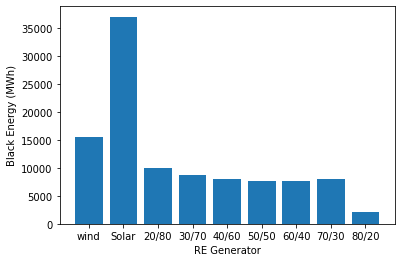

In [11]:
# 3(b). Find and plot total firming energy under different RE generator profiles
total_load_2021 = np.sum(profiles['total_load'])
firming_by_re_gen = {}
#percent_load_not_covered = {}
for id, data in residuals_dict.items():
    total_firming = np.sum(residuals_dict[id]['Black'])
    firming_by_re_gen[id] = total_firming / 1000
    #percent_load_not_covered[id] = total_firming / total_load_2021

plt.bar(range(len(firming_by_re_gen)), list(firming_by_re_gen.values()), align='center')
plt.xticks(range(len(firming_by_re_gen)), list(firming_by_re_gen.keys()))
plt.xlabel('RE Generator')
plt.ylabel('Black Energy (MWh)')
plt.show()

In [12]:
# 4. Calculate PPA costs
ppa_costs = ppa.calc(contract_type='Off-site - Contract for Difference',
                     ppa_volume='RE Uptill Load',  # In each 30 min interval the PPA volume is the lesser of generator
                                                   # or load volume.
                     contract_price=50.0,
                     wholesale_volume='RE Uptill Load',  # In each 30 min interval the volume bought from the wholesale
                                                         # market is less of generator or load volume.
                     residual_profiles=residual_profiles,
                     price_profile=prices['RRP']
                     )
print('\n PPA cost summary:')
pprint.pprint(ppa_costs)


 PPA cost summary:
{'Cost of Excess RE': 0.0,
 'Generation shortfall penalty payment': 0,
 'LGC purchase cost': 0,
 'LGC shortfall penalty payment': 0,
 'PPA': -2927545.5490892725,
 'Payment from Excess RE': 0,
 'Payment from wholesale of RE': 0.0,
 'Wholesale cost': 7101426.125256803}


In [13]:
# 5. Define tariffs
applicable_tariffs = pd.DataFrame({
    'Charge name': ['peak', 'off_peak'],
    'Charge Type': ['Energy', 'Energy'],
    'Volume Type': ['Energy ($/MWh)', 'Energy ($/MWh)'],
    'Rate': [85.0,65.0],
    'MLF': [1.0, 1.0],
    'DLF': [1.0, 1.0],
    'Start Month': [1, 1],
    'End Month': [12, 12],
    'Start Weekday': [1, 1],
    'End Weekday': [7, 7],
    'Start Hour': [7, 21],
    'End Hour': [20, 6]
})

In [14]:
# 6. Calculate Tariff costs
tariff_costs = tariffs.calc_tou_set(tou_set=applicable_tariffs, contract_type='Off-site - Contract for Difference',
                                    wholesale_volume='RE Uptill Load', load_profiles=residual_profiles)

print('\n Tariffs and costs summary:')
print(tariff_costs)


 Tariffs and costs summary:
  Charge name Charge Type     Volume Type  Rate  MLF  DLF  Start Month  \
0        peak      Energy  Energy ($/MWh)  85.0  1.0  1.0            1   
1    off_peak      Energy  Energy ($/MWh)  65.0  1.0  1.0            1   

   End Month  Start Weekday  End Weekday  Start Hour  End Hour Alt Load ID  \
0         12              1            7           7        20       Black   
1         12              1            7          21         6       Black   

            Cost  
0  133302.686499  
1   32426.295633  
